In [7]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import time 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support 
%matplotlib inline
from IPython.display import display
from six import StringIO
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D

from scipy.stats import pearsonr
from sklearn.utils import resample

from sklearn.cluster import KMeans 
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import davies_bouldin_score

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

In [51]:
from IPython.display import display, HTML
from sklearn.tree import _tree, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import pandas as pd


def pretty_print(df):
    return display( HTML( df.to_html().replace("\\n","<br>") ) )

def get_class_rules(tree: DecisionTreeClassifier, feature_names: list):
    inner_tree: _tree.Tree = tree.tree_
    classes = tree.classes_
    class_rules_dict = dict()
    
    
    def tree_dfs(node_id=0, current_rule=[]):
        split_feature = inner_tree.feature[node_id]
        if split_feature != _tree.TREE_UNDEFINED: # internal node
            name = feature_names[split_feature]
            threshold = inner_tree.threshold[node_id]
      # left child
            left_rule = current_rule + ["{} <= {}".format(name, threshold)]
            tree_dfs(inner_tree.children_left[node_id], left_rule)
      # right child
            right_rule = current_rule + ["{} > {}".format(name, threshold)]
            tree_dfs(inner_tree.children_right[node_id], right_rule)
        else: # leaf
            dist = inner_tree.value[node_id][0]
            dist = dist/dist.sum()
            max_idx = dist.argmax()
            if len(current_rule) == 0:
                rule_string = "ALL"
            else:
                rule_string = " and ".join(current_rule)
      # register new rule to dictionary
            selected_class = classes[max_idx]
            class_probability = dist[max_idx]
            class_rules = class_rules_dict.get(selected_class, [])
            class_rules.append((rule_string, class_probability))
            class_rules_dict[selected_class] = class_rules
    
    tree_dfs() # start from root, node_id = 0
    return class_rules_dict

def cluster_report(data: pd.DataFrame, clusters, min_samples_leaf=50, pruning_level=0.01):
    #tree = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf, ccp_alpha=pruning_level)
    tree= RandomForestClassifier(max_depth=17)

    tree.fit(data, clusters)
    
    # Generate Report
    feature_names = data.columns
    class_rule_dict = get_class_rules(tree, feature_names)

    report_class_list = []
    for class_name in class_rule_dict.keys():
        rule_list = class_rule_dict[class_name]
        combined_string = ""
        for rule in rule_list:
            combined_string += "[{}] {}\n\n".format(rule[1], rule[0])
        report_class_list.append((class_name, combined_string))
        
    cluster_instance_df = pd.Series(clusters).value_counts().reset_index()
    cluster_instance_df.columns = ['class_name', 'instance_count']
    report_df = pd.DataFrame(report_class_list, columns=['class_name', 'rule_list'])
    report_df = pd.merge(cluster_instance_df, report_df, on='class_name', how='left')
    print(feature_names)
    pretty_print(report_df.sort_values(by='class_name')[['class_name', 'instance_count', 'rule_list']])

    
#def cluster_report(data: pd.DataFrame, clusters, min_samples_leaf=50, pruning_level=0.01):

In [3]:
dataf=pd.read_csv('FULL DATA.csv')

dataf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   AGEGROUP     300 non-null    int64
 1   ageinmonths  300 non-null    int64
 2   PV           300 non-null    int64
 3   SR           300 non-null    int64
 4   GU           300 non-null    int64
 5   REFMNG       300 non-null    int64
 6   RELMNG       300 non-null    int64
 7   EL           300 non-null    int64
 8   TOTAL        300 non-null    int64
dtypes: int64(9)
memory usage: 21.2 KB


In [24]:
dataf.corr(method = 'pearson', min_periods = 1)

,AGEGROUP,ageinmonths,PV,SR,GU,REFMNG,RELMNG,EL,TOTAL
AGEGROUP,1.000000,0.989484,0.760785,0.744749,0.550699,0.791940,0.818825,0.815002,0.938661
ageinmonths,0.989484,1.000000,0.770036,0.753923,0.542752,0.799050,0.823412,0.809715,0.942078
PV,0.760785,0.770036,1.000000,0.647086,0.556428,0.647359,0.594285,0.668376,0.819717
SR,0.744749,0.753923,0.647086,1.000000,0.394013,0.619371,0.645616,0.650380,0.805296
GU,0.550699,0.542752,0.556428,0.394013,1.000000,0.356654,0.428535,0.538894,0.613950
REFMNG,0.791940,0.799050,0.647359,0.619371,0.356654,1.000000,0.693055,0.606768,0.812597
RELMNG,0.818825,0.823412,0.594285,0.645616,0.428535,0.693055,1.000000,0.680759,0.872470
EL,0.815002,0.809715,0.668376,0.650380,0.538894,0.606768,0.680759,1.000000,0.871268
TOTAL,0.938661,0.942078,0.819717,0.805296,0.613950,0.812597,0.872470,0.871268,1.000000


In [25]:
df=dataf.drop(['ageinmonths','GU','TOTAL'], axis = 1)
#df=dataf.drop('TOTAL', axis = 1)
df.head()

,AGEGROUP,PV,SR,REFMNG,RELMNG,EL
0,1,24,0,8,4,2
1,1,19,0,1,4,0
2,1,22,5,0,2,0
3,1,16,2,0,0,1
4,1,19,0,2,0,0


In [28]:
doublelen=int(2*len(df))
#doublelen=doublelen+10

dfsm = resample(df , n_samples=doublelen)
dfsm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600 entries, 177 to 81
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   AGEGROUP  600 non-null    int64
 1   PV        600 non-null    int64
 2   SR        600 non-null    int64
 3   REFMNG    600 non-null    int64
 4   RELMNG    600 non-null    int64
 5   EL        600 non-null    int64
dtypes: int64(6)
memory usage: 32.8 KB


3    104
6    104
5    103
1     99
2     99
4     91
Name: AGEGROUP, dtype: int64

<AxesSubplot:xlabel='AGEGROUP', ylabel='count'>

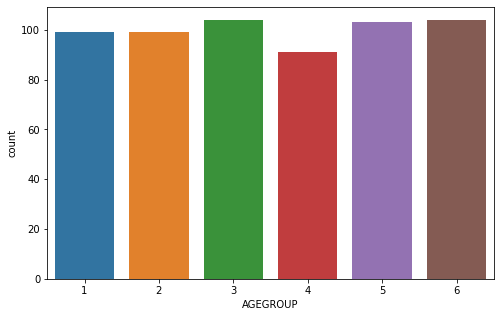

In [30]:
display(dfsm['AGEGROUP'].value_counts().head(30))

plt.figure(figsize=(8,5))
sns.countplot(x="AGEGROUP",data=dfsm)

In [31]:
x=dfsm.iloc[:,1:]
y=dfsm.iloc[:,0]

In [32]:
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test= train_test_split(x,y,test_size=0.3,random_state=0)

The prediction accuracy is:43.33%


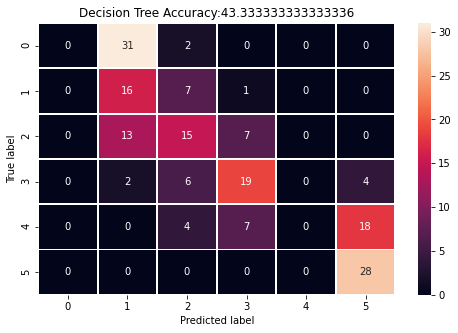

In [33]:
# Import the DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix,precision_recall_fscore_support

# input the decision tree classifier using "entropy" & train the model 
 
xtrain=x_train
xtest=x_test

dtree=DecisionTreeClassifier(criterion='entropy',max_depth=2).fit(xtrain, y_train)

# predict the classes of new, unseen data

predict=dtree.predict(xtest)

print("The prediction accuracy is:{0:2.2f}{1:s}".format(dtree.score(xtest,y_test)*100,"%"))

# Creates a confusion matrix

cm=confusion_matrix(y_test, predict)

# Transform to dataframe for easier plotting
cm_df=pd.DataFrame(cm) 

plt.figure(figsize=(8,5))
sns.heatmap(cm_df, annot=True,linewidths=1, fmt = 'd')

plt.title("Decision Tree Accuracy:"+str(dtree.score(xtest,y_test)*100))
plt.ylabel('True label')
plt.xlabel('Predicted label')


from six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

#dot_data=StringIO()
#export_graphviz(dtree, out_file=dot_data,filled=True, rounded=True,special_characters=True)

#graph=pydotplus.graph_from_dot_data(dot_data.getvalue())
#Image(graph.create_png())

Text(0.5, 24.0, 'Predicted label')

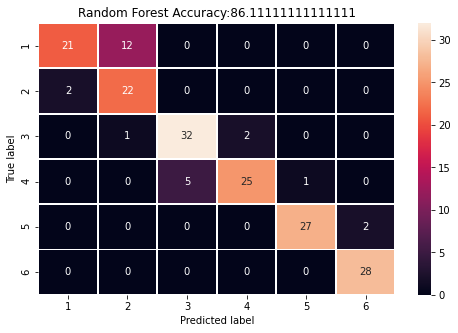

In [62]:
from sklearn.ensemble import RandomForestClassifier

#max_depth=6,,min_samples_leaf=2,n_estimators=100
crf=RandomForestClassifier(max_depth=17)

#Train the model using the training sets y_pred=clf.predict(X_test)
crf.fit(x_train,y_train)

y_pred=crf.predict(x_test)


cmrf=confusion_matrix(y_test, y_pred)

# Transform to dataframe for easier plotting
cmrf_df=pd.DataFrame(cmrf, index=['1','2','3','4','5','6'],columns=['1','2','3','4','5','6']) 



plt.figure(figsize=(8,5))
sns.heatmap(cmrf_df, annot=True,linewidths=1, fmt = 'd')

plt.title("Random Forest Accuracy:"+str(crf.score(x_test,y_test)*100))
plt.ylabel('True label')
plt.xlabel('Predicted label')





In [63]:
from sklearn.feature_selection import SelectFromModel

sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(x_train, y_train)

sel.get_support()

selected_feat= x_train.columns[(sel.get_support())]
#len(selected_feat)
print(selected_feat)
pd.series(sel.estimator_,feature_importances_,ravel()).hist()


Index(['RELMNG', 'EL'], dtype='object')


AttributeError: module 'pandas' has no attribute 'series'

In [52]:
cluster_report(x_train, y_train, min_samples_leaf=50, pruning_level=0.01)

AttributeError: 'RandomForestClassifier' object has no attribute 'tree_'

              precision    recall  f1-score   support

           1       0.76      0.79      0.78        33
           2       0.45      0.54      0.49        24
           3       0.63      0.63      0.63        35
           4       0.53      0.52      0.52        31
           5       0.52      0.38      0.44        29
           6       0.81      0.89      0.85        28

    accuracy                           0.63       180
   macro avg       0.62      0.62      0.62       180
weighted avg       0.62      0.63      0.62       180

[[26  5  2  0  0  0]
 [ 8 13  2  1  0  0]
 [ 0 11 22  2  0  0]
 [ 0  0  8 16  7  0]
 [ 0  0  1 11 11  6]
 [ 0  0  0  0  3 25]]


Text(0.5, 24.0, 'Predicted label')

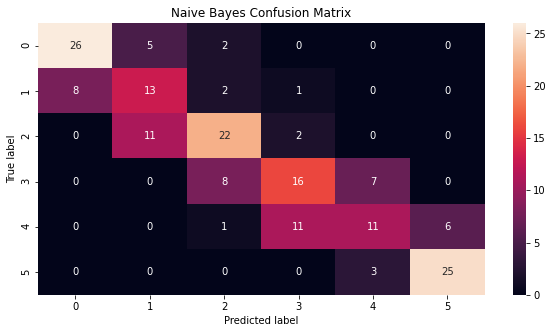

In [44]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB, ComplementNB
from sklearn.metrics import classification_report

gnb=GaussianNB()
gnb.fit(x_train,y_train)

by_predict=gnb.predict(x_test)


cmnb = confusion_matrix(y_test, by_predict)
print(classification_report(y_test, by_predict))
print(cmnb)
# Transform to dataframe for easier plotting 
cmnb_df = pd.DataFrame(cmnb)

plt.figure(figsize=(10,5)) 
sns.heatmap(cmnb_df, annot=True, fmt='g') 
plt.title("Naive Bayes Confusion Matrix") 
plt.ylabel('True label') 
plt.xlabel('Predicted label')

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        33
           2       0.22      0.96      0.36        24
           3       0.67      0.11      0.20        35
           4       0.25      0.03      0.06        31
           5       0.00      0.00      0.00        29
           6       0.44      1.00      0.62        28

    accuracy                           0.31       180
   macro avg       0.26      0.35      0.20       180
weighted avg       0.27      0.31      0.19       180



C:\Program Files\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Program Files\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Program Files\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 24.0, 'Predicted label')

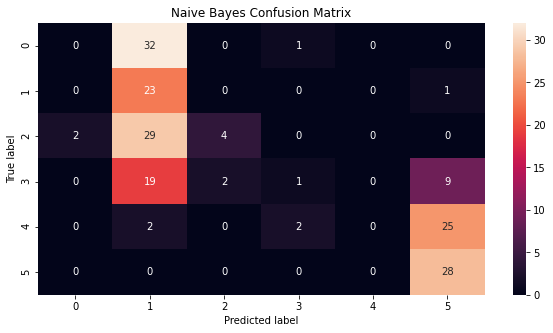

In [45]:
cnb=ComplementNB()
cnb.fit(x_train,y_train)

cnb_predict=cnb.predict(x_test)


cmcnb = confusion_matrix(y_test, cnb_predict)
print(classification_report(y_test, cnb_predict))

# Transform to dataframe for easier plotting 

plt.figure(figsize=(10,5)) 
sns.heatmap(cmcnb, annot=True, fmt='g') 
plt.title("Naive Bayes Confusion Matrix") 
plt.ylabel('True label') 
plt.xlabel('Predicted label')

              precision    recall  f1-score   support

           1       0.72      0.70      0.71        33
           2       0.31      0.33      0.32        24
           3       0.45      0.63      0.52        35
           4       0.33      0.23      0.27        31
           5       0.29      0.21      0.24        29
           6       0.52      0.57      0.54        28

    accuracy                           0.46       180
   macro avg       0.44      0.44      0.43       180
weighted avg       0.44      0.46      0.44       180



Text(0.5, 24.0, 'Predicted label')

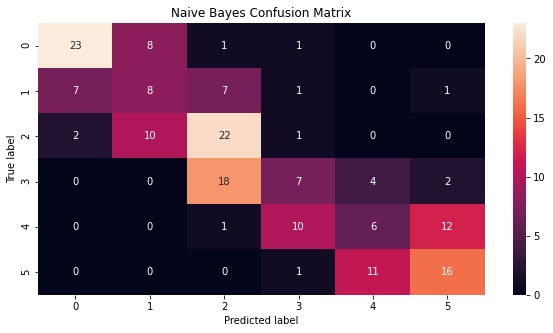

In [46]:
mnb=MultinomialNB()
mnb.fit(x_train,y_train)

mnb_predict=mnb.predict(x_test)


cmmnb = confusion_matrix(y_test, mnb_predict)
print(classification_report(y_test, mnb_predict))

# Transform to dataframe for easier plotting 

plt.figure(figsize=(10,5)) 
sns.heatmap(cmmnb, annot=True, fmt='g') 
plt.title("Naive Bayes Confusion Matrix") 
plt.ylabel('True label') 
plt.xlabel('Predicted label')

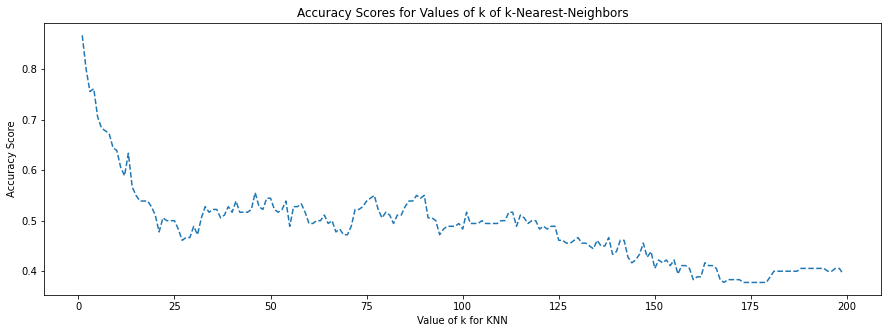

86.66666666666667
0


In [47]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

scores=[]
# We try different values of k for the KNN (from k=1 up to k=26)
lrange=list(range(1,200))
# loop the KNN process
for k in lrange:
    # input the k value and 'distance' measure
    knn=KNeighborsClassifier(n_neighbors=k)
    # input the train data to train KNN
    knn.fit(x_train,y_train)
    # see KNN prediction by inputting the test data
    y_pred=knn.predict(x_test)
    # append the performance metric (accuracy)
    scores.append(metrics.accuracy_score(y_test,y_pred))

    

plt.figure(2,figsize=(15,5))
# plot the results
plt.plot(lrange, scores,ls='dashed')
plt.xlabel('Value of k for KNN')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Scores for Values of k of k-Nearest-Neighbors')
plt.show()

maxscoreknn=max(scores)
print(maxscoreknn*100)
print(scores.index(maxscoreknn))

              precision    recall  f1-score   support

           1       0.76      0.58      0.66        33
           2       0.33      0.42      0.37        24
           3       0.56      0.69      0.62        35
           4       0.59      0.55      0.57        31
           5       0.55      0.38      0.45        29
           6       0.73      0.86      0.79        28

    accuracy                           0.58       180
   macro avg       0.59      0.58      0.57       180
weighted avg       0.60      0.58      0.58       180



C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Text(0.5, 24.0, 'Predicted label')

<Figure size 720x360 with 0 Axes>

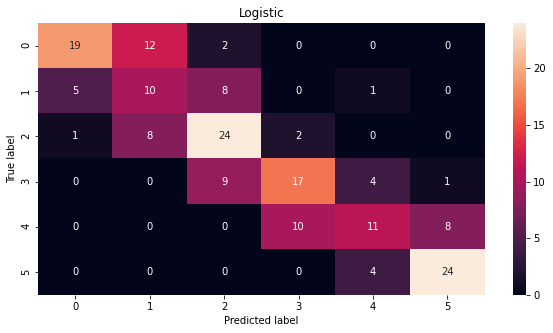

In [48]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()

# fit the model with data
logreg.fit(x_train,y_train)

#
ylg_pred=logreg.predict(x_test)

cmlg = confusion_matrix(y_test, ylg_pred)
print(classification_report(y_test, ylg_pred))

plt.figure(figsize=(10,5))

plt.figure(figsize=(10,5)) 
sns.heatmap(cmlg, annot=True, fmt='g') 
plt.title("Logistic") 
plt.ylabel('True label') 
plt.xlabel('Predicted label')